## Build and track our portfolio based on our trades.

### Doesn't have any concept of buy and sell just yet.  only that a position is bought and held

In [1]:
import pandas as pd
import yfinance as yf
import plotly.graph_objects as go

Spoofing the data for now. Could come from xlsx or  pull from broker if there is an API

In [170]:
data = {'tickers': ['BTC-AUD', 'BOE.AX', 'PDN.AX'] ,
        'prices': [10000, 0.34, 0.40 ],
        'amounts': [0.01, 3000, 2100],
        'dates': ['2021-01-01', '2020-02-01', '2021-01-01']}  # Spoofing for now. Could come from xlsx or  pull from broker if there is an API

We load the data into a pandas dataframe

In [171]:
trade_data = pd.DataFrame.from_dict(data)

In [172]:
trade_data.head()

,tickers,prices,amounts,dates
0,BTC-AUD,10000.00,0.01,2021-01-01
1,BOE.AX,0.34,3000.00,2020-02-01
2,PDN.AX,0.40,2100.00,2021-01-01


So we wish to see how each trade has done on a daily basis.  We will use yfinance for now, could get from any number of APIs 

If you haven't already, `pip install yfinance` in a terminal

Lets define some constants which we will use to setup the scope of our analysis

In [173]:
PERIOD = '1D' # Daily
END = '2021-06-05' #  could use datetime.now

In [174]:
quotes = [] # empty list for storing quotes

for ticker, date in zip(trade_data['tickers'], trade_data['dates'] ):
    _quote = yf.Ticker(ticker)
    quotes.append(_quote.history(period=PERIOD, start=date, end=END))

In [175]:
quotes[0].head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-12-31,37515.300781,38024.976562,36470.363281,37668.855469,60727639338,0,0
2021-01-01,37658.839844,38417.914062,37410.789062,38181.992188,52943282221,0,0
2021-01-02,38184.984375,43096.679688,37814.171875,41760.628906,88214867182,0,0
2021-01-03,41763.410156,44985.933594,41663.203125,42511.105469,102011582370,0,0
2021-01-04,42548.613281,43360.960938,37133.984375,41686.386719,105824510347,0,0


In [176]:
quotes[1].head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-02-03,0.048,0.048,0.047,0.048,2475057,0,0
2020-02-04,0.048,0.048,0.046,0.047,749366,0,0
2020-02-05,0.047,0.047,0.045,0.046,1720348,0,0
2020-02-06,0.046,0.046,0.044,0.044,811628,0,0
2020-02-07,0.044,0.047,0.044,0.047,415795,0,0


----------
Lets open some candlestick charts [Helpful link](https://coderzcolumn.com/tutorials/data-science/candlestick-chart-in-python-mplfinance-plotly-bokeh)  Lets use Plotly for now.  `pip install plotly`

To use Plotly need to install [Node.js](https://nodejs.org/en/download/current/)    Do this by typing into a terminal

`conda install jodejs`   
followed by:   
`jupyter labextension install @jupyterlab/plotly-extension`   
----------------

Now lets make a little dropdown box for us to chose the ticker we want to see below in the plot    
`conda install ipywidgets`    
`jupyter labextension install @jupyter-widgets/jupyterlab-manager`


In [177]:
from ipywidgets import interact, interact_manual

In [178]:
@interact()
def make_plot(ticker=data['tickers']):

    ii = data['tickers'].index(ticker)
    candlestick = go.Candlestick(x=quotes[ii].index,
                                open=quotes[ii]['Open'],
                                high=quotes[ii]['High'],
                                low=quotes[ii]['Low'],
                                close=quotes[ii]['Close'])

    fig = go.Figure(data=[candlestick])
    fig.update_layout(xaxis_rangeslider_visible=False,
                     title=trade_data['tickers'][ii],
                     template='plotly_dark')

    fig.show()

interactive(children=(Dropdown(description='ticker', options=('BTC-AUD', 'BOE.AX', 'PDN.AX'), value='BTC-AUD')…

Now we need to generate our port folio based on the ticker data.  Dealing with datetimes is always painful

In [179]:
from datetime import datetime
_dates = []

for date in data['dates']:
    _dates.append(datetime.strptime(date, '%Y-%m-%d').date())


date_range = pd.date_range(start=min(_dates), end=END, freq='D')

In [180]:
date_range

DatetimeIndex(['2020-02-01', '2020-02-02', '2020-02-03', '2020-02-04',
               '2020-02-05', '2020-02-06', '2020-02-07', '2020-02-08',
               '2020-02-09', '2020-02-10',
               ...
               '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
               '2021-05-31', '2021-06-01', '2021-06-02', '2021-06-03',
               '2021-06-04', '2021-06-05'],
              dtype='datetime64[ns]', length=491, freq='D')

In [226]:
df = None
portfolio = date_range.to_frame()
frames = [portfolio]

for ii in range(len(data['tickers'])):
    print(ii)
    frames.append(quotes[ii]['Close'] * data['amounts'][ii])

df = pd.concat(frames, axis=1)
df = df.drop(df.columns[0], axis=1)

df.columns = data['tickers']

portfolio = df

0
1
2


In [232]:
portfolio.fillna(method='ffill', inplace=True)  ## forward fill.  so on weekends we carry forward Friday's value


In [233]:
portfolio['Total'] = portfolio.sum(axis=1)  # add to total as a column

In [230]:
portfolio

,BTC-AUD,BOE.AX,PDN.AX,Total
2020-02-01,NaN,NaN,NaN,0.000000
2020-02-02,NaN,NaN,NaN,0.000000
2020-02-03,NaN,144.000001,NaN,144.000001
2020-02-04,NaN,140.999995,NaN,140.999995
2020-02-05,NaN,138.000000,NaN,138.000000
...,...,...,...,...
2021-06-01,473.003320,495.000020,1050.000000,2018.003340
2021-06-02,485.198164,524.999991,1249.500060,2259.698215
2021-06-03,511.663398,510.000005,1196.999985,2218.663389
2021-06-04,476.592344,495.000020,1260.000050,2231.592413


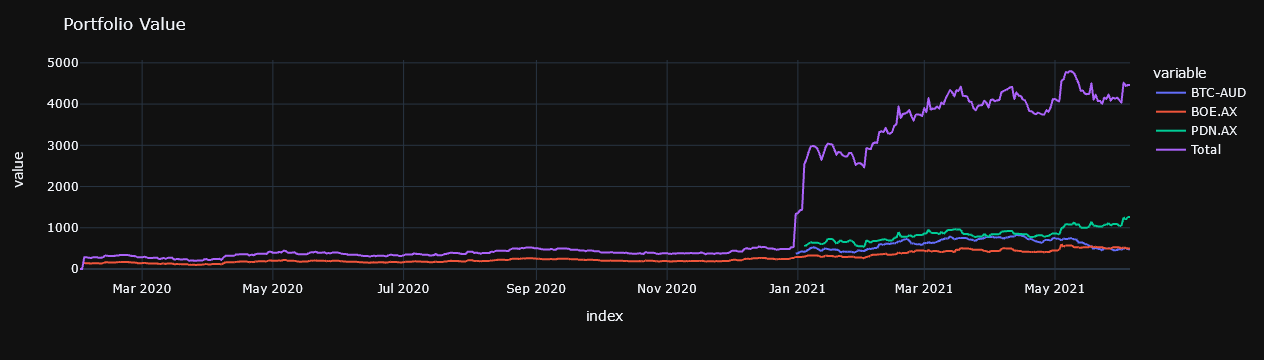

In [235]:
import plotly.express as px

fig = px.line(portfolio)
fig.update_layout(xaxis_rangeslider_visible=False,
                 title='Portfolio Value',
                 template='plotly_dark')
fig.show()